Importing necessary packages

In [1]:
import pandas as pd
#removes false positive pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


importing SQLite and connecting to flightsDB.db database

In [2]:
#importing sqlite and opening flightsDB database
import sqlite3 as db
con = db.connect('flightsDB.db')
c = con.cursor()

I decided to narrow my focus and analyze flights departing from and arriving to San Diego International Airport.
(this dataframe is small enough to not cause my kernel to crash)

In [19]:
#querying all relevant data for flights departing San Diego International(SAN) and arriving at Chicago O'Hare (ORD)
san_departures = pd.read_sql_query('''
                                      SELECT  Year AS year,
                                              Month AS month,
                                              DayofMonth AS day_of_month,
                                              DayOfWeek AS day_of_week,
                                              DepTime AS dep_time,
                                              CRSDepTime AS sched_dep_time,
                                              ArrTime AS arr_time,
                                              CRSArrTime AS sched_arr_time,
                                              UniqueCarrier AS carrier,
                                              FlightNum AS flight_number,
                                              TailNum AS tail_number,
                                              ActualElapsedTime AS actual_time,
                                              CRSElapsedTime AS predicted_time,
                                              AirTime AS airtime,
                                              ArrDelay AS arrival_delay,
                                              DepDelay AS departure_delay,
                                              Cancelled AS cancelled,
                                              CancellationCode AS cancellation_code,
                                              Diverted AS diverted,
                                              CarrierDelay AS carrier_delay,
                                              WeatherDelay AS weather_delay,
                                              NASDelay AS NAS_delay,
                                              SecurityDelay AS security_delay,
                                              LateAircraftDelay AS late_aircraft_delay                            
                                      FROM  flights
                                      WHERE Origin = 'SAN' 
                                            AND Dest = 'ORD'                                      
                                    ''', con)

#querying airport data
airports = pd.read_sql_query(''' 
                                SELECT iata,
                                        airport,
                                        city,
                                        state
                                FROM airports
                            ''', con)

#querying carrier data
carriers = pd.read_sql_query('''
                                SELECT Code AS carrier_code,
                                        Description AS carrier_name
                                FROM carriers
                            ''', con)

#querying relevant plane data
plane_data = pd.read_sql_query('''
                                SELECT tailnum,
                                        type,
                                        manufacturer,
                                        issue_date,
                                        model,
                                        status,
                                        year
                                FROM plane_data
                                ''', con)

print(san_departures.shape)

(43742, 24)


After dropping duplicate rows, the number of rows is identical, indicating there were no duplicate rows in the dataframe.

In [158]:
san_dep_clean = san_departures.drop_duplicates()
print(san_dep_clean.shape)

(43742, 24)


The only columns containing null data are the cancellation_code and tail_number columns. When the  dep dataset is subset for cancellation = 1 (flight was cancelled) there are no null values for cancellation code. This shows that all the null values seen are for flights that were not cancelled and are not entry errors. 

Out of the cancelled flights, 18 have null values for tail numbers. This could be because the cancelled flights were never assigned to a specific plane. None of the non-cancelled flights had null values for tail numbers.

In [159]:
#null data for flights
print(san_dep_clean.isna().sum())


year                       0
month                      0
day_of_month               0
day_of_week                0
dep_time                   0
sched_dep_time             0
arr_time                   0
sched_arr_time             0
carrier                    0
flight_number              0
tail_number               18
actual_time                0
predicted_time             0
airtime                    0
arrival_delay              0
departure_delay            0
cancelled                  0
cancellation_code      17434
diverted                   0
carrier_delay              0
weather_delay              0
NAS_delay                  0
security_delay             0
late_aircraft_delay        0
dtype: int64


(769, 24)


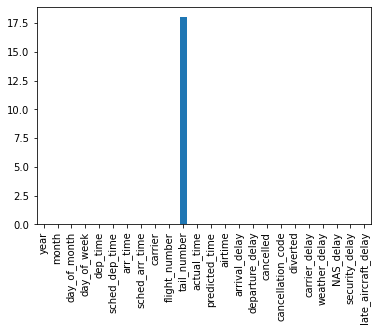

In [160]:
#subsetting for cancelled departures and visualizing null data
san_dep_cancelled = san_dep_clean[san_dep_clean['cancelled'] == 1]
print(san_dep_cancelled.shape)

san_dep_cancelled.isna().sum().plot(kind='bar')
plt.show()


It appears that 549 of the plane tailnumbers do not contain data. These null values are not useful to me as they will not give me any information about the make, model, and year of the plane. Therefore I will drop the null rows.

549 rows of data were dropped from this dataset, leaving 4480 rows containing data on the aircraft for each tail number.

In [161]:
#visualizing null data for other data tables
print(airports.isna().sum())

print(carriers.isna().sum())

print(plane_data.isna().sum())


#dropping null rows for plane_data and verifying
plane_data_clean = plane_data.dropna()
print(plane_data_clean.isna().sum())
print(plane_data.shape)
print(plane_data_clean.shape)

iata       0
airport    0
city       0
state      0
dtype: int64
carrier_code    0
carrier_name    0
dtype: int64
tailnum           0
type            549
manufacturer    549
issue_date      549
model           549
status          549
year            549
dtype: int64
tailnum         0
type            0
manufacturer    0
issue_date      0
model           0
status          0
year            0
dtype: int64
(5029, 7)
(4480, 7)


Many columns containing numeric data currently are an object data type which is restricting the ability to perform aggregate analysis on them and using excess system memory. I will convert them to float datatypes, starting by converting 'NA' text to 0. Then converting the object dtype to a string and then to a float.

In [162]:
#replacing NA values with 0s and converting numeric object datatypes to float
convert_to_float_columns = ['actual_time', 'predicted_time', 'airtime', 'arrival_delay', 'departure_delay',\
                          'carrier_delay', 'weather_delay', 'NAS_delay', 'security_delay', 'late_aircraft_delay']

for i in convert_to_float_columns:
    san_dep_clean[i] = san_dep_clean[i].replace('NA', 0)
    san_dep_clean[i] = san_dep_clean[i].astype(str).astype(float)


print(san_dep_clean.dtypes)

year                     int64
month                    int64
day_of_month             int64
day_of_week              int64
dep_time                object
sched_dep_time           int64
arr_time                object
sched_arr_time           int64
carrier                 object
flight_number            int64
tail_number             object
actual_time            float64
predicted_time         float64
airtime                float64
arrival_delay          float64
departure_delay        float64
cancelled                int64
cancellation_code       object
diverted                 int64
carrier_delay          float64
weather_delay          float64
NAS_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object


Creating a new timestamp column for departure time, arrival time, sched_arr_time, and sched_dep_time. 


In [163]:
#converting timestamp columns to strings
col_to_timestamp = ['year', 'month', 'day_of_month', 'dep_time', 'arr_time', 'sched_arr_time', 'sched_dep_time']
for i in col_to_timestamp:
    san_dep_clean[i] = san_dep_clean[i].astype(str)

#function to add colon between hrs and mins for time columns
def insert_colon_hrs_mins(string):
        if len(string) == 3:
            return ('0' + string[:1] + ':' + string[1:])
        elif string == '2400':
            return '23:59'
        elif len(string) == 4:
            return (string[:2] + ':' + string[2:])
        else:
            return '0:00'

#looping function over time columns in datasets to apply the insert colon function to each time value in the datasets
time_columns = ['dep_time', 'arr_time', 'sched_arr_time', 'sched_dep_time']
for i in time_columns:
    san_dep_clean[i] = san_dep_clean[i].apply(lambda x: insert_colon_hrs_mins(x))
                                              

#concatenating strings for new datetime columns in YYYY-MM-DD hh:mm format
dataframes = [san_dep_clean]
for i in dataframes:
    i['date'] = i['year'] + '-' + i['month'] + '-' + i['day_of_month']
    i['dep_dt'] = i['year'] + '-' + i['month'] + '-' + i['day_of_month'] + ' ' + i['dep_time']
    i['arr_dt'] = i['year'] + '-' + i['month'] + '-' + i['day_of_month'] + ' ' + i['arr_time']
    i['sched_arr_dt'] =  i['year'] + '-' + i['month'] + '-' + i['day_of_month'] + ' ' + i['sched_arr_time']
    i['sched_dep_dt'] =  i['year'] + '-' + i['month'] + '-' + i['day_of_month'] + ' ' + i['sched_dep_time']

#converting new datetime columns from strings to datetime data type
from datetime import datetime
dt_columns = ['date', 'dep_dt', 'arr_dt', 'sched_arr_dt', 'sched_dep_dt']
for i in dt_columns:
    san_dep_clean[i] = pd.to_datetime(san_dep_clean[i], errors='raise')
        
#optimizing datatypes for faster analysis by converting applicable objects to int and dropping redundant columns
to_int = ['year', 'month', 'day_of_month']
to_drop = ['dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time']

for x in to_int:
    san_dep_clean[x] = san_dep_clean[x].astype(int)
for v in to_drop:
    san_dep_clean = san_dep_clean.drop(v, axis='columns')
print(san_dep_clean.dtypes)

print(san_dep_clean.isna().sum())


year                            int64
month                           int64
day_of_month                    int64
day_of_week                     int64
carrier                        object
flight_number                   int64
tail_number                    object
actual_time                   float64
predicted_time                float64
airtime                       float64
arrival_delay                 float64
departure_delay               float64
cancelled                       int64
cancellation_code              object
diverted                        int64
carrier_delay                 float64
weather_delay                 float64
NAS_delay                     float64
security_delay                float64
late_aircraft_delay           float64
date                   datetime64[ns]
dep_dt                 datetime64[ns]
arr_dt                 datetime64[ns]
sched_arr_dt           datetime64[ns]
sched_dep_dt           datetime64[ns]
dtype: object
year                       0
month  

Now that all of the SAN data has been cleaned and data types are correct, exploration can begin!

Number of departures and arrivals track very closely with very little deviation from each oter. There appears to be an annual oscillation in the data, hinting at some seasonality trends. There isn't a significant trend in flights over time for this particular route.

Slicing the dataset for 2001-01-01 to 2002-01-01 we can see that this decline occured during September 2001. This may be due to heightened anxiety about flying after the terrorist attack on 9/11/2001.


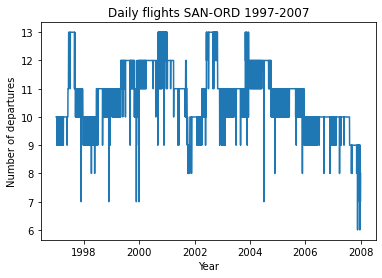

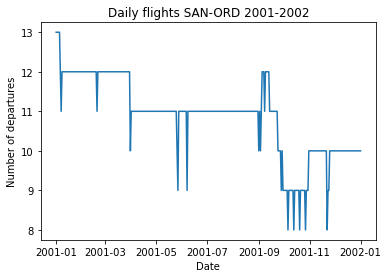

In [164]:
#counting flights per day
dep_by_year = san_dep_clean.groupby('date').count()

#visualizing flights per day data
fig, ax = plt.subplots()
ax.plot(dep_by_year.index, dep_by_year['year'])
ax.set_ylabel("Number of departures")
ax.set_xlabel('Year')
ax.set_title("Daily flights SAN-ORD 1997-2007")
plt.show()

#slicing for 2001-2002 flights per day
dep_by_year_slice_2001_2002 = dep_by_year.loc['2001-01-01':'2002-01-01']

#visualizing 2001-2002 flights per day
fig, ax = plt.subplots()
ax.plot(dep_by_year_slice_2001_2002.index, dep_by_year_slice_2001_2002['year'])
ax.set_ylabel("Number of departures")
ax.set_xlabel('Date')
ax.set_title("Daily flights SAN-ORD 2001-2002")
plt.show()

Looking into cancellations and causes

In [165]:
#creating new dataframes filtered for cancelled and diverted flights
cancelled_flights_dep = san_dep_clean[san_dep_clean['cancelled'] == 1]


#cancellations over time vs flights over time

It is hard to draw meaningful conclusions from cancellations by reason because the majority of cancellations do not have a reason listed. 

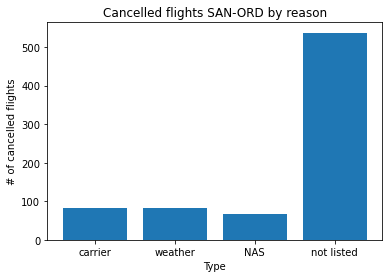

In [166]:
#number of cancelled flights by code
num_of_cancelled_dep_by_code = cancelled_flights_dep.groupby('cancellation_code')['cancelled'].count().to_frame().reset_index()

#updating with cause of cancellation for each code
cancel_codes = {'A':'carrier', 'B':'weather', 'C':'NAS', 'D':'security', 'NA':'not listed'}
num_of_cancelled_dep_by_code['reason'] = num_of_cancelled_dep_by_code['cancellation_code'].apply(lambda x: cancel_codes[x])

#visualizing cancellation by reason
fig, ax = plt.subplots()
ax.bar(num_of_cancelled_dep_by_code['reason'], num_of_cancelled_dep_by_code['cancelled'])
ax.set_xlabel('Type')
ax.set_ylabel('# of cancelled flights')
ax.set_title('Cancelled flights SAN-ORD by reason')
plt.show()


Only 3 airlines run direct flights between SAN and ORD. Continental Airlines has a cancellation rate twice as high as American Airlines or United Airlines cancellation rate. By avoiding Continental Airlines and flying United Airlines or American Airlines we can reduce the average flight cancellation rate between SAN and ORD by over 0.5%.

/tmp/ipykernel_1607/3404035851.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(percent_cancel_dep_airline['carrier_name'], rotation=90)


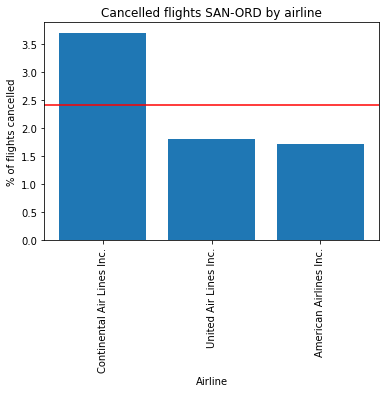

In [167]:
#cancellations by airline (largest listed cause of cancellations)

#calculating number of cancelled flights by carrier
cancel_dep_by_carrier = cancelled_flights_dep.groupby('carrier')['cancelled'].count().to_frame().reset_index()

#calculating total flights by carrier
total_dep_by_carrier = san_dep_clean.groupby('carrier')['date'].count().to_frame().rename(columns={'date':'total_flights'})\
                        .reset_index()


#joining total and cancelled flights by carrier
percent_cancel_dep_carrier = cancel_dep_by_carrier.merge(total_dep_by_carrier, on='carrier')

#calculating percentage column for cancellations
percent_cancel_dep_carrier['percent_cancelled'] = percent_cancel_dep_carrier['cancelled']/\
                                                    percent_cancel_dep_carrier['total_flights']*100

#calculating average cancelled flight percentage
avg_percent_cancel_dep = percent_cancel_dep_carrier['percent_cancelled'].mean()

#joining carrier and cancelled flights datasets and sorting by percentage of cancellations
percent_cancel_dep_airline = percent_cancel_dep_carrier.merge(carriers, left_on='carrier', right_on='carrier_code')\
                        .sort_values(by=['percent_cancelled'], ascending=False)

#visualizing cancellation by airline
fig, ax = plt.subplots()
ax.bar(percent_cancel_dep_airline['carrier_name'], percent_cancel_dep_airline['percent_cancelled'])
ax.set_xticklabels(percent_cancel_dep_airline['carrier_name'], rotation=90)
plt.axhline(y= avg_percent_cancel_dep, color='r', linestyle='-')
ax.set_xlabel('Airline')
ax.set_ylabel('% of flights cancelled')
ax.set_title('Cancelled flights SAN-ORD by airline')
plt.show()


From a cancellation perspective, the best month to book the Q1 meeting would be in March. All three months in Q2 have similar cancellation rates. July or August would be the best month to book the Q3 meeting. October or November would be the best time to book the Q4 meeting.

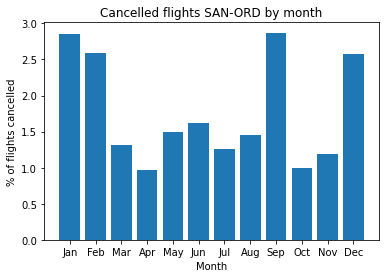

In [168]:
#cancellations grouped by month
cancel_by_month = cancelled_flights_dep.groupby('month')['cancelled'].count().to_frame().reset_index()

#total flights grouped by month
total_by_month = san_dep_clean.groupby('month')['date'].count().to_frame().rename(columns={'date':'total_flights'})\
                        .reset_index()


#joining total and cancelled flights by carrier
percent_cancel_by_month = cancel_by_month.merge(total_by_month, on='month')

#converting month from integer to text abbreviation
import calendar
percent_cancel_by_month['month'] = percent_cancel_by_month['month'].apply(lambda x: calendar.month_abbr[x])

#calculating percentage column for cancellations
percent_cancel_by_month['percent_cancelled'] = percent_cancel_by_month['cancelled']/\
                                                    percent_cancel_by_month['total_flights']*100

#visualizing cancellations by month
fig, ax = plt.subplots()
ax.bar(percent_cancel_by_month['month'], percent_cancel_by_month['percent_cancelled'])
ax.set_xlabel('Month')
ax.set_ylabel('% of flights cancelled')
ax.set_title('Cancelled flights SAN-ORD by month')
plt.show()

The only day of the week that shows significantly fewer cancellations is Sunday. There is a criteria that the flights have to be on weekdays, so any day of the week will face similar cancellation rates.

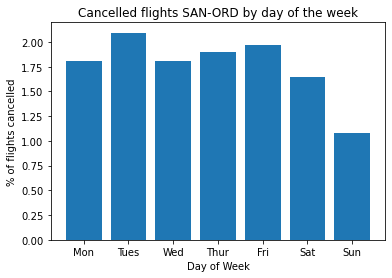

In [169]:
#cancellations grouped by month
cancel_by_dow = cancelled_flights_dep.groupby('day_of_week')['cancelled'].count().to_frame().reset_index()

#total flights grouped by month
total_by_dow = san_dep_clean.groupby('day_of_week')['date'].count().to_frame().rename(columns={'date':'total_flights'})\
                        .reset_index()


#joining total and cancelled flights by carrier
percent_cancel_by_dow = cancel_by_dow.merge(total_by_dow, on='day_of_week')

#converting month from integer to text abbreviation
dow_dictionary = {1:'Mon', 2:'Tues', 3:'Wed', 4:'Thur', 5:'Fri', 6:'Sat', 7:'Sun'}
percent_cancel_by_dow['day_of_week'] = percent_cancel_by_dow['day_of_week'].apply(lambda x: dow_dictionary[x])

#calculating percentage column for cancellations
percent_cancel_by_dow['percent_cancelled'] = percent_cancel_by_dow['cancelled']/\
                                                    percent_cancel_by_dow['total_flights']*100

#visualizing cancellation by day of the week
fig, ax = plt.subplots()
ax.bar(percent_cancel_by_dow['day_of_week'], percent_cancel_by_dow['percent_cancelled'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('% of flights cancelled')
ax.set_title('Cancelled flights SAN-ORD by day of the week')
plt.show()

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

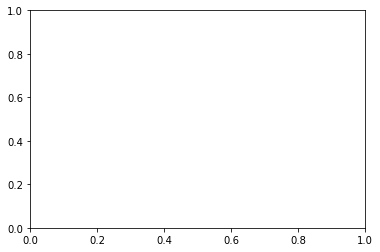

In [170]:
#cancellations grouped by time of day

cancelled_flights_dep['dep_dt'] = cancelled_flights_dep['dep_dt'].dt.round('H').dt.time
san_dep_clean['dep_dt'] = san_dep_clean['dep_dt'].dt.round('H').dt.time
   

cancel_by_time = cancelled_flights_dep.groupby('dep_dt')['cancelled'].count().to_frame().reset_index()
total_by_time = san_dep_clean.groupby('dep_dt')['date'].count().to_frame().rename(columns={'date':'total_flights'})\
                        .reset_index()

percent_cancel_by_time = cancel_by_time.merge(total_by_time, on='dep_dt')

percent_cancel_by_time['percent_cancelled'] = percent_cancel_by_time['cancelled']/percent_cancel_by_time['total_flights']*100

#visualizing cancellation by time of day
fig, ax = plt.subplots()
ax.bar(percent_cancel_by_time['dep_dt'], percent_cancel_by_time['percent_cancelled'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('% of flights cancelled')
ax.set_title('Cancelled flights SAN-ORD by scheduled departure time')
plt.show()

In [ ]:
#creating new dataframes filtered for only delayed flights
delayed_flights_dep = san_dep_clean[san_dep_clean['departure_delay'] > 0]

